# Are 5-star Recruits From the Southeast Better Than Those From other Regions?

In [1]:
import requests
from lxml import html
import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

/Users/shariqiqbal/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Data Scrape

Collect the top 50 recruits from the 24/7 sports composite rankings from 2000-2010 and search for them in the NFL drafts from 2003-2015.  I only collected the recruits up to 2010 because I only wanted to include complete classes, and 5th-year seniors from the class of 2011 have not graduated yet.

In [2]:
top_recruit_lists = {i:'http://247sports.com/Season/%i-Football/CompositeRecruitRankings'%i for i in range(2000, 2011)}
nfl_draft_lists = {i:'https://en.wikipedia.org/wiki/%i_NFL_draft'%i for i in range(2003, 2016)}

In [3]:
headers = {'User-agent': 'bingbot'}
# get 247 composite rankings for every year from 2000-2011
for year in top_recruit_lists:
    top_recruit_lists[year] = requests.get(top_recruit_lists[year], headers=headers)
    time.sleep(0.25) # dont want to spam the server (even though this is a pretty small crawl)

# get NFL Draft results for every year from 2004-2015
for year in nfl_draft_lists:
    nfl_draft_lists[year] = requests.get(nfl_draft_lists[year], headers=headers)
    time.sleep(0.25)

In [4]:
names = []
rank = []
hs_location = []
recruit_year = []

for year in top_recruit_lists:
    tree = html.fromstring(top_recruit_lists[year].content)
    names += tree.xpath('//a[@class="bold"]/text()')
    rank += tree.xpath('//span[@class="primary"]/text()')
    hs_location += tree.xpath('//span[@class="meta"]/text()')
    recruit_year += [year] * len(tree.xpath('//a[@class="bold"]/text()'))

In [5]:
state = []
region = []
state_map =  {'WA': "West",
              'OR': "West",
              'CA': "West",
              'ID': "West",
              'NV': "West",
              'AZ': "West",
              'UT': "West",
              'MT': "West",
              'WY': "West",
              'CO': "West",
              'NM': "West",
              'ND': "Midwest",
              'SD': "Midwest",
              'NE': "Midwest",
              'MN': "Midwest",
              'IA': "Midwest",
              'WI': "Midwest",
              'IL': "Midwest",
              'IN': "Midwest",
              'MI': "Midwest",
              'OH': "Midwest",
              'PA': "Midwest",
              'ME': "East",
              'NH': "East",
              'VT': "East",
              'MA': "East",
              'NY': "East",
              'CT': "East",
              'RI': "East",
              'NJ': "East",
              'DC': "East",
              'DE': "East",
              'MD': "East",
              'WV': "East",
              'VA': "East",
              'NC': "East",
              'MO': "Southeast",
              'KY': "Southeast",
              'TN': "Southeast",
              'SC': "Southeast",
              'GA': "Southeast",
              'AL': "Southeast",
              'MS': "Southeast",
              'LA': "Southeast",
              'FL': "Southeast",
              'AR': "Southeast",
              'KS': "Southwest",
              'TX': "Southwest",
              'OK': "Southwest",
              'HI': "Pacific",
              'AK': "Pacific",
             }
for hs in hs_location:
    st = hs.split(', ')[-1].split(')')[0]
    state.append(st)
    region.append(state_map[st])

In [6]:
df = pd.DataFrame(index=names)
df['rank'] = rank
df['hs_location'] = hs_location
df['recruit_year'] = recruit_year
df['state'] = state
df['region'] = region
df = df.drop('Adam Taliaferro') # mistakenly ranked number 1 by website

In [7]:
for year in nfl_draft_lists:
    tree = html.fromstring(nfl_draft_lists[year].content)
    
    pick_num = tree.xpath("//span[@id]/@id")
    to_remove = []
    for i in range(len(pick_num)):
        val = pick_num[i]
        if 'Pick_' not in val:
            to_remove.append(val)
        else:
            num = val.split('_')[-1]
            try:
                pick_num[i] = int(num)
            except ValueError:
                to_remove.append(val) # wikipedia annoyingly labels forfeited picks as decimals between two picks (e.g. 30.5)

    for rmv in to_remove:
        pick_num.remove(rmv)
    
    names = tree.xpath('//span[@class="sortkey"]/text() | //td/span[@style="display:none;"]/text()')
    for i in range(len(names)):
        name = names[i]
        name = name.split(',')
        name[1] = name[1].replace(' ', '')
        names[i] = name[1] + ' ' + name[0]
    names = names[:len(pick_num)]
    
    for i in range(len(names)):
        name = names[i]
        try:
            if year <= df.loc[name, 'recruit_year'] + 6 and year >= df.loc[name, 'recruit_year'] + 3:
                df.loc[name, 'draft_pick'] = i+1
                df.loc[name, 'draft_year'] = year
        except:
            pass # pick wasn't in 247 top 50 composite

In [8]:
df['drafted'] = (~df.draft_pick.isnull()).astype('int')
df['rank'] = df['rank'].astype('int')

In [9]:
df[df.region == 'Southeast'].drafted.sum() / float(len(df[df.region == 'Southeast']))

0.46568627450980393

In [10]:
df[df.region == 'Midwest'].drafted.sum() / float(len(df[df.region == 'Midwest']))

0.34065934065934067

In [14]:
df.to_pickle('recruit_data.pkl')

## Analysis
Much has been made of the SEC's dominance in college football in recent years, and, some of that success can be attributed to the sheer volume of high profile recruits the region produces.

In [2]:
df = pd.read_pickle('recruit_data.pkl')

In [3]:
region_map = {"West": ['WA','OR','CA','ID','NV','AZ','UT','MT','WY','CO','NM'],
              "Midwest": ['ND','SD','NE','MN','IA','WI','IL','IN','MI','OH','PA'],
              "East": ['ME','NH','VT','MA','NY','CT','RI','NJ','DC','DE','MD','WV','VA','NC'],
              "Southeast": ['MO','KY','TN','SC','GA','AL','MS','LA','FL','AR'],
              "Southwest": ['KS','TX','OK'],
              "Pacific": ['HI','AK']
             }
state_pop =  {'WA': 7170351,
              'OR': 4028977,
              'CA': 39144818,
              'ID': 1654930,
              'NV': 2890845,
              'AZ': 6828065,
              'UT': 2995919,
              'MT': 1032949,
              'WY': 586107,
              'CO': 5456574,
              'NM': 2085109,
              'ND': 756927,
              'SD': 858469,
              'NE': 1896190,
              'MN': 5489594,
              'IA': 3123899,
              'WI': 5771337,
              'IL': 12859995,
              'IN': 6619680,
              'MI': 9922576,
              'OH': 11613423,
              'PA': 12802503,
              'ME': 1329328,
              'NH': 1330608,
              'VT': 626042,
              'MA': 6794422,
              'NY': 19795791,
              'CT': 3590886,
              'RI': 1056298,
              'NJ': 8958013,
              'DC': 672228,
              'DE': 945934,
              'MD': 6006401,
              'WV': 1844128,
              'VA': 8382993,
              'NC': 10042802,
              'MO': 6083672,
              'KY': 4425092,
              'TN': 6600299,
              'SC': 4896146,
              'GA': 10214860,
              'AL': 4858979,
              'MS': 2992333,
              'LA': 4670724,
              'FL': 20271272,
              'AR': 2978204,
              'KS': 2911641,
              'TX': 27469114,
              'OK': 3911338,
              'HI': 1431603,
              'AK': 738432,
             }

In [4]:
region_density = {}
for reg in region_map.keys():
    num_recruits = df[df.region == reg].shape[0]
    pop = 0
    for state in region_map[reg]:
        pop += state_pop[state]
    
    recruits_per_mil = (float(num_recruits) / pop) * 1000000
    region_density[reg] = recruits_per_mil

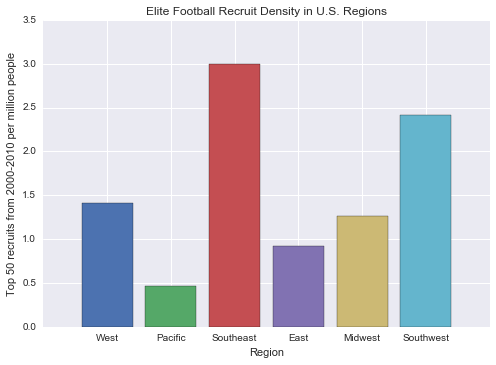

In [14]:
plt.bar(range(1, len(region_density)+1), region_density.values(), 
        color=sns.color_palette("deep", 10)[:6], align='center',
        tick_label=region_density.keys())
plt.xlabel("Region")
plt.ylabel('Top 50 recruits from 2000-2010 per million people')
plt.title('Elite Football Recruit Density in U.S. Regions');

Could it be possible, though, that these high profile recruits from the Southeast are also superior to their contemporaries from other regions of the US?